<a href="https://colab.research.google.com/github/pdh93621/Deep-learning/blob/main/Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np

from sklearn.model_selection import train_test_split

import matplotlib.ticker as ticker
import matplotlib.pyplot as plt

import time
import re
import os
import io

In [2]:
path_to_zip = tf.keras.utils.get_file('spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip', extract=True)

In [3]:
path_to_file = os.path.dirname(path_to_zip)+ "/spa-eng/spa.txt"

In [4]:
with open(path_to_file, "r") as f:
  raw = f.read().splitlines()

print("Data Size: ", len(raw))
print("Example:")

for sen in raw[0:100][::20]: print(">>", sen)

Data Size:  118964
Example:
>> Go.	Ve.
>> Wait.	Esperen.
>> Hug me.	Abrázame.
>> No way!	¡Ni cagando!
>> Call me.	Llamame.


In [5]:
def preprocess_sentence(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)

    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [6]:
eng_corpus = []
dec_corpus = []

num_examples = 30000

for pair in raw[:num_examples]:
  eng, spa = pair.split("\t")

  eng_corpus.append(preprocess_sentence(eng))
  dec_corpus.append(preprocess_sentence(spa, s_token=True, e_token=True))

print("English :", eng_corpus[100])
print("Spanish :", dec_corpus[100])

English : go away !
Spanish : <start> salga de aqu ! <end>


In [7]:
def tokenize(corpus):
  tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  tokenizer.fit_on_texts(corpus)

  tensor = tokenizer.texts_to_sequences(corpus)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

  return tensor, tokenizer

In [8]:
# 토큰화 하기
# 훈련데이터와 검증데이터로 분리하기
# 정제된 텍스트를 아래 tokenize()함수를 사용해 토큰화해서 텐서로 변환하세요~
enc_tensor, enc_tokenizer = tokenize(eng_corpus)
dec_tensor, dec_tokenizer = tokenize(dec_corpus)

In [9]:
# 그리고 변환된 텐서를 80%의 훈련데이터와 20% 검증데이터로 분리하세요
# 단 Tokenizer의 단어수는 자유롭게 진행하세요!
enc_train, enc_val, dec_train, dec_val = train_test_split(enc_tensor, dec_tensor, test_size = 0.2)

In [10]:
# english vocab size반환
# spanish vocab size반환
print('English Vocab Size :',len(enc_tokenizer.index_word))
print('Spanish Vocab Size :',len(dec_tokenizer.index_word))

English Vocab Size : 4931
Spanish Vocab Size : 8893


In [11]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.w_dec = tf.keras.layers.Dense(units)
    self.w_enc = tf.keras.layers.Dense(units)
    self.w_com = tf.keras.layers.Dense(1)

  def call(self, h_enc, h_dec):
    # h_enc shape : [batch x length x units]
    # h_dec shape : [batch x units]

    h_enc = self.w_enc(h_enc)
    h_dec = tf.expand_dims(h_dec, 1)
    h_dec = self.w_dec(h_dec)

    score = self.w_com(tf.nn.tanh(h_dec + h_enc))

    attn = tf.nn.softmax(score, axis =1)

    context_vec = attn * h_enc
    context_vec = tf.reduce_sum(context_vec, axis=1)
    return context_vec, attn

In [12]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    # todo
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(enc_units, return_sequences=True)

  def call(self, x):
    # todo 
    out = self.embedding(x)
    out = self.gru(out)

    return out

In [13]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    ## Todo
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(dec_units, return_sequences=True, return_state=True)
    self.fc = tf.keras.layers.Dense(vocab_size)
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, h_dec, enc_out):
    ## Todo
    context_vec, attn = self.attention(enc_out, h_dec)
    
    out = self.embedding(x)
    out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)

    out, h_dec = self.gru(out)
    out = tf.reshape(out, (-1, out.shape[2]))
    out = self.fc(out)

    return out, h_dec, attn

In [14]:
BATCH_SIZE = 64
src_vocab_size = len(enc_tokenizer.index_word) + 1
tgt_vocab_size = len(dec_tokenizer.index_word) + 1

units = 1024
embedding_dim = 512

encoder = Encoder(src_vocab_size, embedding_dim, units)
decoder = Decoder(tgt_vocab_size, embedding_dim, units)

# sample input
sequence_len = 30

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))
sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_state, sample_output)

print('Decoder output :', sample_logits.shape)
print('Decoder Hidden State :', h_dec.shape)
print('Attention :', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder output : (64, 8894)
Decoder Hidden State : (64, 1024)
Attention : (64, 30, 1)


In [15]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
# Categorical Crossentropy()
# [0.1, 0.2, 0.7] --> onehot encoding [0, 0, 1]
# SparseCategoricalCrossentropy()
# [0.1, 0.2, 0.7] ---> 정수 인덱스 2
# True --> 모델의 출력값을 그대로 전달

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  return tf.reduce_mean(loss)  

In [16]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
  bsz = src.shape[0]
  loss = 0

  with tf.GradientTape() as tape:
    enc_out = encoder(src)
    h_dec = enc_out[:, -1]

    dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

    for t in range(1, tgt.shape[1]):
      pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

      loss += loss_function(tgt[:, t], pred)
      dec_src = tf.expand_dims(tgt[:,t], 1)

  batch_loss = (loss/int(tgt.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  return batch_loss

train_step 학습 과정
1. Encoder에 소스 문장을 전달해 컨텍스트 벡터인 enc_out 생성
2. Decoder에 입력으로 전달할 <start> 토큰 문장 생성
3. t=0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의. h_dec = enc_out[:,-1]
4. 문장과 enc_out, Hidden State를 기반으로 다음단어(t=1)예측, pred

In [17]:
from tqdm import tqdm
import random

epochs = 10

for epoch in range(epochs):
  total_loss = 0

  idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
  random.shuffle(idx_list)
  t = tqdm(idx_list)

  for (batch, idx) in enumerate(t):
    batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                            dec_train[idx:idx+BATCH_SIZE],
                            encoder,
                            decoder,
                            optimizer,
                            dec_tokenizer)
    total_loss += batch_loss

    t.set_description_str('Epoch %2d' % (epoch+1))
    t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch+1)))

Epoch 10: 100%|██████████| 375/375 [01:02<00:00,  6.05it/s, Loss 0.1421]


### Evaluation step

Input: can i have some coffee ?
Predicted translation: me dan algo de caf ? <end> 


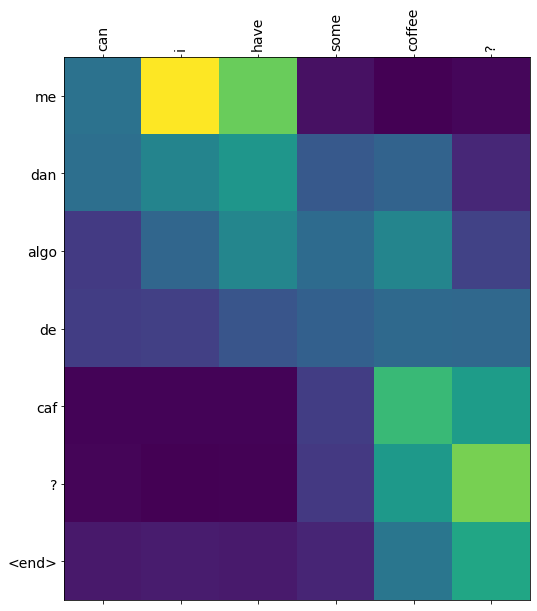

In [19]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    inputs = enc_tokenizer.texts_to_sequences([sentence.split()])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    for t in range(dec_train.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))


translate("Can I have some coffee?", encoder, decoder)